In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from pymatching import Matching
import networkx as nx
import time

In [10]:
l = 3 # number of sublattice points (2 for toric code) or primal/dual
prob_l = 0.2 # loss rate
prob_z = 0.02 # bit flip rate

r = 10 # cluster dim
r1 = r # dimension of cube
r2 = r # dimension of cube
r3 = r # dimension of cube

# star stabilzers
Sx = np.zeros((r1*r2*r3,l*r1*r2*r3))
for ix in range(r1):
    for iy in range(r2):
        for iz in range(r3):
            Sx[ix + r1*(iy+ r2*iz), l*(ix + r1*(iy+ r2*iz))] = 1
            Sx[ix + r1*(iy+ r2*iz), l*(ix + r1*(iy+ r2*iz))+1] = 1
            Sx[ix + r1*(iy+ r2*iz), l*(ix + r1*(iy+ r2*iz))+2] = 1
            Sx[ix + r1*(iy+ r2*iz), l*( ((ix-1)%r1) + r1*(iy+ r2*iz))] = 1
            Sx[ix + r1*(iy+ r2*iz), l*(ix + r1*( ((iy-1)%r2)+ r2*iz) )+1] = 1
            Sx[ix + r1*(iy+ r2*iz), l*(ix + r1*(iy+ r2* ((iz-1)%r3)) )+2] = 1

logicals = np.zeros((3,l*r1*r2*r3))
## x ops
for i1 in range(r2):
    logicals[0,np.ix_(3*np.arange(i1*r1,r1*r2*r3,r1*r2))] = np.ones(r3)
for i1 in range(r3):
    logicals[1,np.ix_(1+ 3*(i1*r1*r2+ np.arange(0,r1) ) )] = np.ones(r1)
logicals[2,2:3*r1*r2+1:3] = np.ones(r1*r2) 

tic = time.time()

def compute_eff_Sx(Sx,loss_inds,remain_inds):
    Sx_new = []
    inds_new = []
    Sx_old = np.copy(Sx)
    inds_old = list(range(r1*r2*r3))
    for loss_index in loss_inds:
        st_ind = np.argwhere(Sx_old[:,loss_index]>0)
        st_ind = list(st_ind[:,0])
        # ## possibly more efficient
        # if loss_index%3 ==0:
        #     x2 = (((int(loss_index/3)%(r1*r2))%r1) +1 ) % r1
        #     y2 = int((int(loss_index/3)%(r1*r2))/r1)
        #     z2 = int(int(loss_index/3)/(r1*r2))
        # elif loss_index%3 == 1:
        #     x2 = ((int(loss_index/3)%(r1*r2))%r1) 
        #     y2 = (int((int(loss_index/3)%(r1*r2))/r1)+1)%r2
        #     z2 = int(int(loss_index/3)/(r1*r2))            
        # else:
        #     x2 = ((int(loss_index/3)%(r1*r2))%r1) 
        #     y2 = int((int(loss_index/3)%(r1*r2))/r1)
        #     z2 = (int(int(loss_index/3)/(r1*r2))+1)%r3
        # q2 = (z2*r2+y2)*r1 + x2
        # star_ops = np.array([int(loss_index/3),q2])
        # st_ind = list(star_ops[np.argwhere(Sx_old[np.ix_(star_ops),loss_index]>0)][:,1])
        # # st_ind = list(np.sort(st_ind2[:,1]))
        # # if not np.array_equal(st_ind2,st_ind):
        #     # print(st_ind,st_ind2)

        if len(st_ind)==2:
            inds_new.append(st_ind)
            # Stot = np.zeros(l*r1*r2*r3)
            # for i_remove in st_ind:
            #     inds_old.remove(i_remove)
            #     Stot += Sx_old[i_remove,:]
            # Sx_new.append(list(Stot%2)) 
            inds_old.remove(st_ind[0])
            inds_old.remove(st_ind[1])
            Sx_new.append(list((Sx_old[st_ind[0],:]+Sx_old[st_ind[1],:])%2))
            Sx_old[st_ind,:] = 0
        elif len(st_ind)==1:
            st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)[0,0]
            inds_new[st_new_ind][:] += st_ind
            inds_old.remove(st_ind[0])
            Sx_new[st_new_ind] = list((np.array(Sx_new)[st_new_ind,:]+Sx_old[st_ind[0],:]) %2)
            Sx_old[st_ind,:] = 0
        else:
            st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)
            if len(st_new_ind)>1:
                st_new_ind = list(st_new_ind[:,0])
                inds_new[st_new_ind[0]][:] += inds_new[st_new_ind[1]][:]
                # Stot = np.zeros(l*r1*r2*r3)
                # for i_remove in st_new_ind:
                #     Stot += np.array(Sx_new)[i_remove,:]        
                # Sx_new[st_new_ind[0]] = list(Stot%2)
                Sx_new[st_new_ind[0]] = list((np.array(Sx_new)[st_new_ind[0],:]+np.array(Sx_new)[st_new_ind[1],:] )%2)
                del inds_new[st_new_ind[1]]
                del Sx_new[st_new_ind[1]]
    Sx_new = np.array(Sx_new, dtype=int)

    # for loss_index in loss_inds:
    #     st_ind = np.argwhere(Sx_old[:,loss_index]>0)
    #     st_new_ind = np.argwhere(Sx_new[:,loss_index]>0)
    #     assert len(st_ind)+len(st_new_ind)==0

    num_Sx_red = len(inds_new)+len(inds_old)
    Sx_red = np.zeros((num_Sx_red,len(remain_inds)),dtype=int)
    Sx_red[0:len(inds_old),:] = Sx_old[np.ix_(inds_old,remain_inds)]
    if len(inds_new)>0:
        Sx_red[len(inds_old):,:] = Sx_new[:,remain_inds]

    keep_cols = np.argwhere(np.sum(Sx_red,axis=0)>0)[:,0]
    Sx_red = Sx_red[:,keep_cols]

    qubits_to_plot = remain_inds[keep_cols]
    return Sx_red, qubits_to_plot

##################
def netx_Sx(Sx_red,overlap,qubits_to_plot):
    inds_to_keep = list(range(np.size(Sx_red,1)))
    nl = []
    counter = 0
    i = 0 
    while counter < np.size(Sx_red,1):
        edge = inds_to_keep[i]
        ovlp_inds = np.argwhere(overlap[edge,inds_to_keep[i+1:]]==2)
        if len(ovlp_inds)>0:
            # for j in ovlp_inds[::-1,0]:
            #     inds_to_keep.remove(inds_to_keep[i+1+j])
            inds_to_keep = list(set(inds_to_keep) - set(list(np.array(inds_to_keep)[i+1+ovlp_inds[:,0]])))
            counter += (len(ovlp_inds)+1)
            nl.append(len(ovlp_inds)+1)
        else:
            counter += 1
            nl.append(1)
        i += 1
    
    # weights2 = np.zeros(l*r1*r2*r3)
#     while counter < np.size(Sx_red,1):
#         edge = inds_to_keep[i]
#         ovlp_inds = np.argwhere(overlap[edge,inds_to_keep[i+1:]]==2)
#         if len(ovlp_inds)>0:
#             # print("edge= ", edge)
#             nl_i = len(ovlp_inds)+1
#             weights2[qubits_to_plot[edge]] = nl_i
#             for j in ovlp_inds[::-1,0]:
#                 # print(inds_to_keep[i+1+j])
#                 weights2[qubits_to_plot[inds_to_keep[i+1+j]]] = nl_i
#                 inds_to_keep.remove(inds_to_keep[i+1+j])

#             # print(inds_to_keep)
#             counter += nl_i
#             nl.append(nl_i)
#         else:
#             counter += 1
#             nl.append(1)
#             weights2[qubits_to_plot[edge]] = 1
#         i += 1
        
# # Sx_red_netx = Sx_red[:,inds_to_keep]
    # remain_qubits = remain_inds[keep_cols[inds_to_keep]]
    remain_qubits = qubits_to_plot[inds_to_keep]
    nl = np.array(nl)
    
    # return Sx_red_netx, remain_qubits, inds_to_keep, nl
    # return remain_qubits, inds_to_keep, nl, weights2
    return remain_qubits, inds_to_keep, nl


def netx_Sx_eff(Sx_red,overlap,qubits_to_plot):
      
    inds = np.argwhere(overlap>1)
    rep_edges = []
    inds_red = []
    for i_v in inds:
        if i_v[1]>i_v[0]:
            if not (i_v[0] in rep_edges):
                rep_edges.append(i_v[0])
            if not (i_v[1] in rep_edges):
                rep_edges.append(i_v[1])

    rep_edges = np.sort(rep_edges)
    not_rep_qubits = np.array(list(set(range(np.size(Sx_red,1))) - set(rep_edges)))
    inds_red = np.array(inds_red)

    ql2 = []
    nl2 = []
    nl_x2 = []
    nl_y2 = []
    counter = 0
    i = 0 
    overlap2 = overlap[np.ix_(rep_edges,rep_edges)]
    inds_to_keep2 = list(range(len(rep_edges)))
    while counter < len(rep_edges):
        edge = inds_to_keep2[i]
        ovlp_inds = np.argwhere(overlap2[edge,inds_to_keep2[i+1:]]==2)
        if qubits_to_plot[rep_edges[edge]] %l ==0:
            nl_i_x = 1
            nl_i_y = 0 
        else:
            nl_i_x = 0 
            nl_i_y = 1
        nl_i = len(ovlp_inds)+1

        qlist = qubits_to_plot[rep_edges[np.ix_([ inds_to_keep2[k] for k in i+1+ovlp_inds[:,0]])]]
        ovlp_inds_x = np.argwhere(qlist %l==0)
        ovlp_inds_y = np.argwhere(qlist %l >0)
        nl_i_x += len(ovlp_inds_x)
        nl_i_y += len(ovlp_inds_y)
        for j in ovlp_inds[::-1,0]:
            inds_to_keep2.remove(inds_to_keep2[i+1+j])
        ql2.append(np.concatenate(([qubits_to_plot[rep_edges[edge]]],qlist)))
        counter += nl_i
        nl2.append(nl_i)
        nl_x2.append(nl_i_x)
        nl_y2.append(nl_i_y)
        i += 1

    nl_x_tot = np.zeros(len(inds_to_keep2)+len(not_rep_qubits))
    nl_x_tot[ np.argwhere(qubits_to_plot[not_rep_qubits]%l ==0)  ] = 1 
    nl_x_tot[len(not_rep_qubits):] = nl_x2

    nl_y_tot = np.zeros(len(inds_to_keep2)+len(not_rep_qubits))
    nl_y_tot[ np.argwhere(qubits_to_plot[not_rep_qubits]%l >0)  ] = 1 
    nl_y_tot[len(not_rep_qubits):] = nl_y2

    nl_tot = np.concatenate((np.ones(len(not_rep_qubits)),nl2))
    # ql_tot = []
    # for i in range(len(nl_tot)):
    #     ql_tot.append(not_rep_qubits[i])

    inds_to_keep2 = rep_edges[inds_to_keep2]
    comb_inds = np.concatenate((not_rep_qubits,inds_to_keep2))
    inds_sorted = np.argsort(comb_inds)
    inds_to_keep2 = comb_inds[inds_sorted]
    nl_x_tot = nl_x_tot[inds_sorted]
    nl_y_tot = nl_y_tot[inds_sorted]
    nl_tot = nl_tot[inds_sorted]
    remain_qubits = qubits_to_plot[inds_to_keep2]

    return remain_qubits, inds_to_keep2, nl_tot
    
    
## loss error
error_loss = np.random.rand(l*r1*r2*r3) 
loss_inds = np.argwhere(error_loss < prob_l)[:,0]
remain_inds = np.argwhere(error_loss >= prob_l)[:,0]
# percolate_y, percolate_x = does_loss_percolate(loss_inds) 
# loss_percolate = (percolate_x or percolate_y)
# if loss_percolate:
    # # fail_prob_z +=  1
    # loss_prob +=  1
    # continue
error_loss[loss_inds] = 1
error_loss[remain_inds] = 0

t1 = time.time()
########
Sx_red, qubits_to_plot = compute_eff_Sx(Sx,loss_inds,remain_inds)
t2 = time.time()
# lost_qubits = np.array(list(set(np.arange(l*r1*r2*r3)) - set(qubits_to_plot)))
# percolate_y, percolate_x = does_loss_percolate(lost_qubits)
# loss_percolate = (percolate_x or percolate_y)
# if loss_percolate:
#     # fail_prob_z +=  1
#     loss_prob +=  1
#     continue

overlap = Sx_red.T@Sx_red
################
# Sx_red_netx, remain_qubits, inds_to_keep, nl = netx_Sx(Sx_red,overlap,qubits_to_plot)
remain_qubits, inds_to_keep, nl = netx_Sx(Sx_red,overlap,qubits_to_plot)
t3 = time.time()
remain_qubits2, inds_to_keep2, nl2 = netx_Sx_eff(Sx_red,overlap,qubits_to_plot)

t4 = time.time()

assert np.sum(np.abs(nl2-nl)) == 0
assert np.sum(np.abs(inds_to_keep2-inds_to_keep)) == 0


num_edge = len(remain_qubits) 

pl = (1-(1-2*prob_z)**nl)/2
########## weights on square lattice ############
weights = np.zeros(l*r1*r2*r3)
weights[remain_qubits] = nl#np.log((1-pl)/pl) 

inds_to_keep_2 = list(range(np.size(Sx_red,1)))
for i in range(num_edge):
    edge = inds_to_keep[i]
    ovlp_inds = np.argwhere(overlap[edge,inds_to_keep_2[i+1:]]==2)
    if len(ovlp_inds)>0:
        for j in ovlp_inds[::-1,0]:
            weights[qubits_to_plot[inds_to_keep_2[i+1+j]]] = nl[i]#np.log((1-pl[i])/pl[i]) 

assert len(np.argwhere(weights>0))== len(qubits_to_plot)


error_table = np.random.rand(num_edge) < pl
zflip_inds = np.argwhere(error_table == True)[:,0]
no_zflip_inds = np.argwhere(error_table == False)[:,0]
error_z_orig = np.zeros(l*r1*r2*r3,dtype=int)
error_z_orig[remain_qubits[zflip_inds]] = 1

if num_edge > 1:
    m_orig = Matching(Sx,spacelike_weights=weights)
t5 = time.time()


# find syndrome
syndrome_x_orig = Sx@error_z_orig % 2
synd_x_inds = np.argwhere(syndrome_x_orig > 0)
if len(synd_x_inds)>0:
    rec2_orig = m_orig.decode(syndrome_x_orig)
    rec2_orig_inds = np.argwhere(rec2_orig > 0)[:,0]

    error_rec_orig = (rec2_orig + error_z_orig )%2
    s_orig = np.dot( error_rec_orig , logicals.T) %2 
    if np.sum(s_orig)  > 0:
        print("failed")
toc = time.time()
t_vec = [t1,t2,t3,t4,t5,toc]
print(np.diff(t_vec))
print("Finished in %.2f secs" % (toc-tic))


failed
[14.72580385  2.14214969  0.11260581  0.34772587  0.04446602]
Finished in 17.37 secs


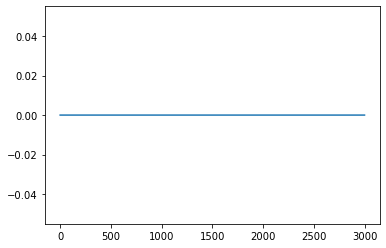

In [16]:
plt.plot(weights-weights2)

In [ ]:
for i_L, L in enumerate(L_list):
    plt.plot(pz0_list,fail_prob_z0[i_L,:]/Nrep,"o-", label="L=%d" % (L))
    
plt.xlabel("bit flip error prob.")
plt.ylabel("logical error prob.")
# plt.yscale("log")
plt.legend()
plt.show()

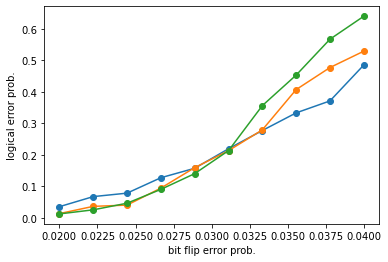

In [24]:
plt.plot(pz0_list,fail_prob_z0.T/Nrep,"o-")
# plt.plot(px_list,fail_prob_x.T/Nrep,"x-")
plt.xlabel("bit flip error prob.")
plt.ylabel("logical error prob.")
# plt.yscale("log")
plt.show()

In [27]:
repeat = 1
Nrep_loss = 1 # number of iterations
Nrep_flip = 1 # number of iterations
L_list = [6]#[16,24,32] # [8,12,16,20]
prob_l = 0.1 # loss rate
pz_list = [0.02]#np.linspace(0.01,0.1,6) #np.arange(0.02,0.071,0.005) 

for i_rep in np.arange(repeat):
    for i_L, r in enumerate(L_list):
        print("L= ", r, " rep= ", i_rep)
        fail_prob_z = np.zeros(len(pz_list))
        loss_prob = 0

        r1 = r # dimension of cube
        r2 = r # dimension of cube
        r3 = r # dimension of cube
        logicals = np.zeros((3,l*r1*r2*r3))
        ## x ops
        for i1 in range(r2):
            logicals[0,np.ix_(3*np.arange(i1*r1,r1*r2*r3,r1*r2))] = np.ones(r3)
        for i1 in range(r3):
            logicals[1,np.ix_(1+ 3*(i1*r1*r2+ np.arange(0,r1) ) )] = np.ones(r1)
        logicals[2,2:3*r1*r2+1:3] = np.ones(r1*r2) 


        tic = time.time()

        def does_loss_percolate(loss_inds):
            Gy = nx.Graph()
            Gy.add_nodes_from(np.arange(r1*r2))
            Gx = nx.Graph()
            Gx.add_nodes_from(np.arange(r1*r2))


            for i2 in range(r2):
                for i1 in range(r1):
                    ind1 = i2*r1+ i1
                    ind2 = i2*r1 + ((i1+1)%r1)
                    # cylinder along y
                    if 2*ind1 in loss_inds:
                        Gy.add_edge(ind1,ind2)
                    if ind1 +r1 < r1*r2 and 2*ind1+1 in loss_inds:
                        Gy.add_edge(ind1,ind1+r1)
                    # cylinder along x
                    ind2 = ((i2+1)%r2)*r1 + i1
                    if 2*ind1+1 in loss_inds:
                        Gx.add_edge(ind1,ind2)
                    if i1+1 < r1 and 2*ind1 in loss_inds:
                        Gx.add_edge(ind1,ind1+1)

            first_row = np.arange(r1)
            last_row = np.arange((r2-1)*r1,r2*r1)
            path_y = False
            for i_first in first_row:
                for i_last in last_row:
                    if nx.has_path(Gy,i_first,i_last):
                        if (i_first - i_last )%r1 ==0: # or 2*i_last+1 in loss_inds
                            path_y = True
                            break
                if path_y:
                    break

            first_col = np.arange(0,(r2-1)*r1+1,r1)
            last_col = np.arange(r1-1,r2*r1+1,r1)
            path_x = False
            for i_first in first_col:
                for i_last in last_col:
                    if nx.has_path(Gx,i_first,i_last):
                        if  int(i_first/r1) == int(i_last/r1): # or 2*i_last in loss_inds
                            path_x = True
                            break
                if path_x:
                    break

            for i in range(len(loss_inds)):
                ind1 = int(loss_inds[i]/2)
                if loss_inds[i] % 2 == 0 :
                    ind2 = int(int(loss_inds[i]/2)/r1)*r1 + (((int(loss_inds[i]/2)%r1)+1)%r1)
                    assert Gy.has_edge(ind1,ind2)
                    ind2 = ind1 + 1
                    if (int(loss_inds[i]/2)%r1)+1 < r1:
                        assert Gx.has_edge(ind1,ind2)     
                else:
                    ind2 = ind1 + r1
                    if ind2 < r1*r2:
                        assert Gy.has_edge(ind1,ind2)
                    ind2 = ((int(int(loss_inds[i]/2)/r1)+1)%r2)*r1 + (int(loss_inds[i]/2)%r1)
                    assert Gx.has_edge(ind1,ind2)
            return path_y,path_x

        def compute_eff_Sx(Sx,loss_inds,remain_inds):
            Sx_new = []
            inds_new = []
            Sx_old = np.copy(Sx)
            inds_old = list(range(r1*r2*r3))
            for loss_index in loss_inds:
                st_ind = np.argwhere(Sx_old[:,loss_index]>0)
                st_ind = list(st_ind[:,0])
                if len(st_ind)==2:
                    inds_new.append(st_ind)
                    Stot = np.zeros(l*r1*r2*r3)
                    for i_remove in st_ind:
                        inds_old.remove(i_remove)
                        Stot += Sx_old[i_remove,:]
                    Sx_new.append(list(Stot%2)) 
                    Sx_old[st_ind,:] = 0
                elif len(st_ind)==1:
                    st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)[0,0]
                    inds_new[st_new_ind][:] += st_ind
                    inds_old.remove(st_ind[0])
                    Sx_new[st_new_ind] = list((np.array(Sx_new)[st_new_ind,:]+Sx_old[st_ind[0],:]) %2)
                    Sx_old[st_ind,:] = 0
                else:
                    st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)
                    if len(st_new_ind)>1:
                        st_new_ind = list(st_new_ind[:,0])
                        inds_new[st_new_ind[0]][:] += inds_new[st_new_ind[1]][:]
                        Stot = np.zeros(l*r1*r2*r3)
                        for i_remove in st_new_ind:
                            Stot += np.array(Sx_new)[i_remove,:]        
                        Sx_new[st_new_ind[0]] = list(Stot%2)
                        del inds_new[st_new_ind[1]]
                        del Sx_new[st_new_ind[1]]
            Sx_new = np.array(Sx_new, dtype=int)

            for loss_index in loss_inds:
                st_ind = np.argwhere(Sx_old[:,loss_index]>0)
                st_new_ind = np.argwhere(Sx_new[:,loss_index]>0)
                assert len(st_ind)+len(st_new_ind)==0

            num_Sx_red = len(inds_new)+len(inds_old)
            Sx_red = np.zeros((num_Sx_red,len(remain_inds)),dtype=int)
            Sx_red[0:len(inds_old),:] = Sx_old[np.ix_(inds_old,remain_inds)]
            if len(inds_new)>0:
                Sx_red[len(inds_old):,:] = Sx_new[:,remain_inds]

            keep_cols = np.argwhere(np.sum(Sx_red,axis=0)>0)[:,0]
            Sx_red = Sx_red[:,keep_cols]

            qubits_to_plot = remain_inds[keep_cols]
            return Sx_red, qubits_to_plot

        ##################
        def netx_Sx(Sx_red,overlap,qubits_to_plot):
            inds_to_keep = list(range(np.size(Sx_red,1)))
            nl = []
            counter = 0
            i = 0 
            while counter < np.size(Sx_red,1):
                edge = inds_to_keep[i]
                ovlp_inds = np.argwhere(overlap[edge,inds_to_keep[i+1:]]==2)
                if len(ovlp_inds)>0:
                    for j in ovlp_inds[::-1,0]:
                        inds_to_keep.remove(inds_to_keep[i+1+j])
                    counter += (len(ovlp_inds)+1)
                    nl.append(len(ovlp_inds)+1)
                else:
                    counter += 1
                    nl.append(1)
                i += 1

            Sx_red_netx = Sx_red[:,inds_to_keep]
            # remain_qubits = remain_inds[keep_cols[inds_to_keep]]
            remain_qubits = qubits_to_plot[inds_to_keep]
            nl = np.array(nl)
            return Sx_red_netx, remain_qubits, inds_to_keep, nl

        ##################
        # star stabilzers
        Sx = np.zeros((r1*r2*r3,l*r1*r2*r3))
        for ix in range(r1):
            for iy in range(r2):
                for iz in range(r3):
                    Sx[ix + r1*(iy+ r2*iz), l*(ix + r1*(iy+ r2*iz))] = 1
                    Sx[ix + r1*(iy+ r2*iz), l*(ix + r1*(iy+ r2*iz))+1] = 1
                    Sx[ix + r1*(iy+ r2*iz), l*(ix + r1*(iy+ r2*iz))+2] = 1
                    Sx[ix + r1*(iy+ r2*iz), l*( ((ix-1)%r1) + r1*(iy+ r2*iz))] = 1
                    Sx[ix + r1*(iy+ r2*iz), l*(ix + r1*( ((iy-1)%r2)+ r2*iz) )+1] = 1
                    Sx[ix + r1*(iy+ r2*iz), l*(ix + r1*(iy+ r2* ((iz-1)%r3)) )+2] = 1


        for i_loss in range(Nrep_loss):

           ## loss error
            error_loss = np.random.rand(l*r1*r2*r3) 
            loss_inds = np.argwhere(error_loss < prob_l)[:,0]
            remain_inds = np.argwhere(error_loss >= prob_l)[:,0]
            # percolate_y, percolate_x = does_loss_percolate(loss_inds) 
            # loss_percolate = (percolate_x or percolate_y)
            # if loss_percolate:
                # # fail_prob_z +=  1
                # loss_prob +=  1
                # continue
            error_loss[loss_inds] = 1
            error_loss[remain_inds] = 0

            Sx_red, qubits_to_plot = compute_eff_Sx(Sx,loss_inds,remain_inds)

            lost_qubits = np.array(list(set(np.arange(l*r1*r2*r3)) - set(qubits_to_plot)))
            # percolate_y, percolate_x = does_loss_percolate(lost_qubits)
            # loss_percolate = (percolate_x or percolate_y)
            # if loss_percolate:
            #     # fail_prob_z +=  1
            #     loss_prob +=  1
            #     continue

            overlap = Sx_red.T@Sx_red
            Sx_red_netx, remain_qubits, inds_to_keep, nl = netx_Sx(Sx_red,overlap,qubits_to_plot)
            num_edge = len(remain_qubits) 
            ################
            for i_p, prob_z in enumerate(pz_list):
                for i_n in range(Nrep_flip):

                    pl = (1-(1-2*prob_z)**nl)/2
                    ########## weights on square lattice ############
                    weights = np.zeros(l*r1*r2*r3)
                    weights[remain_qubits] = np.log((1-pl)/pl) 

                    inds_to_keep_2 = list(range(np.size(Sx_red,1)))
                    for i in range(num_edge):
                        edge = inds_to_keep[i]
                        ovlp_inds = np.argwhere(overlap[edge,inds_to_keep_2[i+1:]]==2)
                        if len(ovlp_inds)>0:
                            for j in ovlp_inds[::-1,0]:
                                weights[qubits_to_plot[inds_to_keep_2[i+1+j]]] = np.log((1-pl[i])/pl[i]) 

                    assert len(np.argwhere(weights>0))== len(qubits_to_plot)

                    error_table = np.random.rand(num_edge) < pl
                    zflip_inds = np.argwhere(error_table == True)[:,0]
                    no_zflip_inds = np.argwhere(error_table == False)[:,0]
                    error_z_orig = np.zeros(l*r1*r2*r3,dtype=int)
                    error_z_orig[remain_qubits[zflip_inds]] = 1

                    if num_edge > 1:
                        m_orig = Matching(Sx,spacelike_weights=weights)
                    else:
                        print("how?")
                        fail_prob_z[i_p] +=  1
                        continue

                    # find syndrome
                    syndrome_x_orig = Sx@error_z_orig % 2
                    synd_x_inds = np.argwhere(syndrome_x_orig > 0)
                    if len(synd_x_inds)>0:
                        rec2_orig = m_orig.decode(syndrome_x_orig)
                        rec2_orig_inds = np.argwhere(rec2_orig > 0)[:,0]

                        error_rec_orig = (rec2_orig + error_z_orig )%2
                        s_orig = np.dot( error_rec_orig , logicals.T) %2 
                        if np.sum(s_orig)  > 0:
                            fail_prob_z[i_p] +=  1

        toc = time.time()
        print("Finished in %d secs" % (toc-tic))
        fname = "data_loss_fcts/" + "p_%.2f_L_%d_i_%d_new.npz" % (prob_l,r,i_rep)
        # np.savez(fname, pz_list=pz_list, loss_prob=loss_prob, fail_prob_z=fail_prob_z, Nrep_loss=Nrep_loss, Nrep_flip=Nrep_flip)

    print("Done!")

L=  6  rep=  0
Finished in 0 secs
Done!
